# What's with the negative parallaxes?
## A simplified demonstration of why a measured parallax can be negative

Any astrometric catalogue that lists parallaxes will contain negative parallaxes, which at first sight appear physically implausible, yet they are an entirely valid measurement of the true positive parallax in the presence of (large) noise. This notebook discusses how negative parallaxes may arise even for "perfect" measurements (suffering only from random Gaussian noise, without any systematic errors).

The astrometry of stars is modelled traditionally as the stars having a uniform motion with respect to the solar system barycentre, which leads to the following (here simplified) description of the apparent direction on the sky $\bar{\boldsymbol{u}}$ as a function of time (see [Lindegren et al. 2012](https://ui.adsabs.harvard.edu/#abs/2012A&A...538A..78L/abstract), and the [Hipparcos (Section 1.2)](https://ui.adsabs.harvard.edu/#abs/1997ESASP1200.....E/abstract) and [Gaia DR1](https://gaia.esac.esa.int/documentation//GDR1/Data_processing/chap_cu3ast/sec_cu3ast_intro.html#SS4) documentation for details)

\begin{equation}
    \bar{\boldsymbol{u}}(t) = \langle \boldsymbol{r} + (t-t_\mathrm{ep})
    (\boldsymbol{p}\mu_{\alpha*} + \boldsymbol{q}\mu_\delta + \boldsymbol{r}\mu_r) - 
    \varpi\boldsymbol{b}_\mathrm{O}(t)/A_\mathrm{u} \rangle\,,
\end{equation}

where the quantities are as follows:
* $\bar{\boldsymbol{u}}$ refers to the topocentric coordinate direction of the source, which is the direction from the observer to the source in the absence of light bending and abberation effects;
* $t$ is the time of observation and $t_\mathrm{ep}$ is the reference epoch for the astrometric parameters (both in units of barycentric coordinate time, or TCB);
* the source astrometric parameters $(\alpha,\delta,\varpi,\mu_{\alpha*},\mu_\delta)$ are all referred to $t_\mathrm{ep}$;
* $\boldsymbol{r}$ is the barycentric coordinate direction to the source at $t_\mathrm{ep}$;
* $\boldsymbol{p}$ and $\boldsymbol{q}$ are unit vectors defined as $\boldsymbol{p}=\langle\boldsymbol{z}\times\boldsymbol{r}\rangle$ and $\boldsymbol{q}=\boldsymbol{r}\times\boldsymbol{p}$ (see below, with $\boldsymbol{z}$ the direction to $(\alpha,\delta)=(0^\circ,90^\circ)$ in the [ICRS](https://ui.adsabs.harvard.edu/#abs/1998A&A...331L..33F/abstract));
* $\boldsymbol{b}_\mathrm{O}(t)$ is the barycentric position of the observer at the time of observation;
* $A_\mathrm{u}$ is the astronomical unit;
* the notation $\langle\rangle$ denotes vector normalization ($\langle\boldsymbol{a}\rangle=\boldsymbol{a}|\boldsymbol{a}|^{-1}$);
* the prime in $\boldsymbol{r}'$ stands for the transpose of a vector or matrix ($\boldsymbol{a}^\prime\boldsymbol{b}$ thus indicating the inner product of the two vectors);
* the components of proper motion along $\boldsymbol{p}$ and $\boldsymbol{q}$ are $\mu_{\alpha*}=\mu_\alpha\cos\delta$ and $\mu_\delta$, respectively;
* $\mu_r=v_r\varpi/A_\mathrm{u}$ is the "radial proper motion" which accounts for the fact that the distance to the to star changes as a consequence of its radial motion, which in turn affects the proper motion and parallax.

The orthogonal vectors $\boldsymbol{p}$, $\boldsymbol{q}$, and $\boldsymbol{r}$ are defined as

\begin{equation}
    \boldsymbol{p} = \begin{pmatrix}
        -\sin\alpha \\ \cos\alpha \\ 0
    \end{pmatrix}\,, \quad
    \begin{matrix}
        \boldsymbol{q} = \begin{pmatrix}
            -\sin\delta\cos\alpha \\ -\sin\delta\sin\alpha \\ \cos\delta
        \end{pmatrix}
    \end{matrix}\,, \quad
    \boldsymbol{r} = \begin{pmatrix}
        \cos\delta\cos\alpha \\ \cos\delta\sin\alpha \\ \sin\delta
    \end{pmatrix}\,.
\end{equation}

These vectors define the so-called normal triad indicating the directions of increasing right ascension $\boldsymbol{p}$, increasing declination $\boldsymbol{q}$, and the coordinate direction of the star $\boldsymbol{r}$.

The equation above is a simplified version of the astrometric source model. It does not include the Roemer delay, which accounts for the fact that the time of observation (at the position of the observer) will occur slightly before or after the light from the source reaches the solar system barycentre (the point to which the astrometric parameters of a source are referred). In the simulation of astrometric observations below the light-bending by bodies in the solar system as well as the abberation due to the motion of the observer are not included. All these simplifications are fine in the context of this simplified demonstration of how negative parallaxes arise. For a full exposition of the astrometric modelling of the positional observations of (single) point sources see [Klioner, 2003](https://ui.adsabs.harvard.edu/#abs/2003AJ....125.1580K/abstract).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import uniform, norm, chi2
from scipy.linalg import lstsq, inv

from astropy import constants
from astropy import units
import corner

from plotstyles import useagab, apply_tufte
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry import constants as pygcst
from pygaia.astrometry.vectorastrometry import astrometryToPhaseSpace

## Simplified simulation of astrometric observations of a source

The code below simulates the observer as being on a circular orbit around the sun, exactly in the ecliptic plane, and with an orbital radius of 1 AU. The topocentric coordinate direction $\bar{\boldsymbol{u}}$ of the source as a function of time is calculated as

\begin{equation}
    \bar{\boldsymbol{u}}(t) = \langle \boldsymbol{b}(t_\mathrm{ep}) + 
    \boldsymbol{v}\times(t-t_\mathrm{ep}) - \boldsymbol{b}_\mathrm{O}(t)\rangle =
    \begin{pmatrix}
        \cos\delta(t)\cos\alpha(t) \\ \cos\delta(t)\sin\alpha(t) \\ \sin\delta(t)
    \end{pmatrix}\,.
\end{equation}

The simulated observations are subsequently reported as

\begin{equation}
    \Delta\alpha* = (\alpha(t)-\alpha(t_\mathrm{ep}))\times\cos\delta(t_\mathrm{ep}) \quad\text{and}\quad
    \Delta\delta = \delta(t)-\delta(t_\mathrm{ep})\,,
\end{equation}

which are the differences in right ascension and declination with respect to the coordinate directions at $t_\mathrm{ep}$ as seen by the observer. These quantities are modelled in the code below as

\begin{gather}
    \Delta\alpha* \approx (t-t_\mathrm{ep})\mu_{\alpha*} -
    \varpi\boldsymbol{p}'\boldsymbol{b}_\mathrm{O}(t)/A_\mathrm{u}\,,\\[5pt]
    \Delta\delta \approx (t-t_\mathrm{ep})\mu_{\delta} -
    \varpi\boldsymbol{q}'\boldsymbol{b}_\mathrm{O}(t)/A_\mathrm{u}\,.
\end{gather}

This is a simplified astrometric model of the source cast in local plane coordinates and ignoring the details of the normalization of the vector $\bar{\boldsymbol{u}}$ (compare to equation 1.2.26 in section 1.2 of the [Hipparcos documentation](https://ui.adsabs.harvard.edu/#abs/1997ESASP1200.....E/abstract)).

**WARNINGS, PLEASE READ**
* **NOTE:** the code below is not numerically robust. It will fail at $\alpha=0$ and $\delta=\pm\pi/2$. In addition the simple system of equations to solve for the parallax and proper motion from the observations will not work in the presence of substantial perspective acceleration.

* **DO NOT use the code below for actual application to high precision astrometry!** Please refer to proper code for astrometric applications such as the [IAU SOFA](http://www.iausofa.org/index.html) library. This library will eventually make it into [astropy](http://www.astropy.org/) (see [Astropy ERFA](https://github.com/astropy/astropy/tree/master/cextern/erfa)).

In [2]:
def ephemeris_earth_simple(t):
    """
    Calculate a very simple ephemeris for "earth" in the BCRS. Assume a perfectly
    circular orbit of exactly 1 AU radius with a 1 yr period.
    
    Parameters
    ----------
    
    t : float array
        Times at which to calculate the ephemeris in Julian years.
        
    Returns
    -------
    
    Array of shape (3,t.size) representing the xyz components of the ephemeris at times t.
    """
    ecltoicrs = CoordinateTransformation(Transformations.ECL2ICRS)
    orbitalperiod = 1.0 #(Julian yr)
    orbitalradius = 1.0 #(AU)
    (b_xecl, b_yecl, b_zecl) = (orbitalradius*np.cos(2*np.pi/orbitalperiod*t), 
                                orbitalradius*np.sin(2*np.pi/orbitalperiod*t), t*0)
    b_xbcrs, b_ybcrs, b_zbcrs = ecltoicrs.transformCartesianCoordinates(b_xecl, b_yecl, b_zecl)
    return np.vstack([b_xbcrs, b_ybcrs, b_zbcrs])
    
def calc_epochpos_topocentric(alpha, delta, parallax, mura, mudec, vrad, t, refepoch, ephem, eqMat=False):
    """
    For each observation epoch calculate the topocentric positions delta_alpha*cos(delta) and 
    delta_delta given the astrometric parameters of a source, the observation times, and the 
    ephemeris (in the BCRS) for the observer.
    
    Parameters
    ----------
    
    alpha : float
        Right ascension at reference epoch (radians)
    delta : float
        Declination at reference epoch (radians)
    parallax : float
        Parallax (mas), negative values allowed
    mura : float
        Proper motion in right ascension, including cos(delta) factor (mas/yr)
    mudec : float
        Proper motion in declination (mas/yr)
    vrad : float
        Radial velocity (km/s)
    t : float array
        Observation times (Julian year)
    refepoch : float
        Reference epoch (Julian year)
    ephem : function
        Funtion providing the observers ephemeris in BCRS at times t (units of AU)
        
    Keywords
    --------
    
    eqMat : boolean
        If True return the equations matrix for solving for proper motion and parallax from a
        set of observations (simplified: ignores radial motion effect and assumes perfectly known
        observation times and a perfectly known position at the reference epoch).
        
    Returns
    -------
    
    Arrays delta_alpha* and delta_delta (local plane coordinates with respect to (alpha, delta)).
    """
    mastorad = np.pi/(180*3600*1000)
    
    if parallax<0:
        signparallax=1
    else:
        signparallax=-1

    # Phase space coordinates at reference epoch. Ignore light travel time from source to observer and take the
    # absolute value of the parallax in order to handle negative parallaxes according to the interpretation that
    # the observer's orbit is then going the other way around the sun.
    bS_x, bS_y, bS_z, vS_x, vS_y, vS_z = astrometryToPhaseSpace(alpha, delta, np.abs(parallax), mura, mudec, vrad)
    
    # Normal triad, defined at the reference epoch.
    p = np.array([-np.sin(alpha), np.cos(alpha), 0.0])
    q = np.array([-np.sin(delta)*np.cos(alpha), -np.sin(delta)*np.sin(alpha), np.cos(delta)])
    r = np.array([np.cos(delta)*np.cos(alpha), np.cos(delta)*np.sin(alpha), np.sin(delta)])

    # Calculate observer's ephemeris and the barycentric time (observation times corrected for Roemer delay).
    bO_bcrs = ephem(t)
    tB = t + (np.dot(r,bO_bcrs))*pygcst.auInMeter/(pygcst.julianYearSeconds*constants.c.value)

    # Phase space coordinates for the observation times.
    bS_bcrs = np.zeros((3,t.size))
    bS_bcrs[0,:] = bS_x+vS_x*(t-refepoch)*(1000*pygcst.julianYearSeconds/pygcst.parsec)
    bS_bcrs[1,:] = bS_y+vS_y*(t-refepoch)*(1000*pygcst.julianYearSeconds/pygcst.parsec)
    bS_bcrs[2,:] = bS_z+vS_z*(t-refepoch)*(1000*pygcst.julianYearSeconds/pygcst.parsec)
    
    uO = bS_bcrs + signparallax * bO_bcrs*pygcst.auInMeter/pygcst.parsec
    alpha_obs = np.arctan2(uO[1,:], uO[0,:])
    indices = (alpha_obs<0)
    alpha_obs[indices] = alpha_obs[indices]+2*np.pi
    delta_obs = np.arcsin(uO[2,:]/np.linalg.norm(uO,axis=0))
                 
    # Calculate the difference between the observed direction to the source at time t and the coordinate direction
    # with respect to the solar system barycentre at the reference epoch (alpha, delta).
    delta_alpha = (alpha_obs - alpha)*np.cos(delta)/mastorad
    delta_delta = (delta_obs - delta)/mastorad
    
    if eqMat:
        nobs = t.size
        A = np.zeros((2*nobs,3))
        A[0:nobs,0] = -np.dot(p,bO_bcrs)
        A[nobs:2*nobs,0] = -np.dot(q,bO_bcrs)
        A[0:nobs,1] = (t-refepoch)
        A[nobs:2*nobs,2] = (t-refepoch)
        return delta_alpha, delta_delta, A
    else:
        return delta_alpha, delta_delta

In [3]:
# Time range and observation time sampling in a separate block to keep observation times constant in the
# subsequent code block.
refepoch = 2015.5
startepoch = 2014.5
endepoch = 2019.5
nobs = 10
    
time = np.linspace(startepoch, endepoch, 1000)
tobs_sample = uniform.rvs(loc=startepoch, scale=endepoch-startepoch, size=nobs)

## Setting up the equations to solve for parallax and proper motion

The next code block simulates the error-free epoch positions of a source with a given set of true astrometric parameters $\alpha$, $\delta$, $\varpi$, $\mu_{\alpha*}$, and $\mu_\delta$. At the same time the system of equations for solving for the astrometric parameters is set up which requires the known observation epochs. The set of equations for a collection of $n$ observing epochs $t_i = \{t_1, \ldots, t_n\}$ is given by:

\begin{equation}
    \begin{pmatrix}
        -\boldsymbol{p}'\boldsymbol{b}_\mathrm{O}(t_1)/A_\mathrm{u} & (t_1-t_\mathrm{ep}) & 0 \\
        \vdots & \vdots & \vdots \\ 
        -\boldsymbol{p}'\boldsymbol{b}_\mathrm{O}(t_n)/A_\mathrm{u} & (t_n-t_\mathrm{ep}) & 0 \\
        -\boldsymbol{q}'\boldsymbol{b}_\mathrm{O}(t_1)/A_\mathrm{u} & 0 & (t_1-t_\mathrm{ep}) \\
        \vdots & \vdots & \vdots \\ 
        -\boldsymbol{q}'\boldsymbol{b}_\mathrm{O}(t_n)/A_\mathrm{u} & 0 & (t_n-t_\mathrm{ep}) \\
    \end{pmatrix}
    \begin{pmatrix}
        \varpi \\ \mu_{\alpha*} \\ \mu_\delta
    \end{pmatrix}
    =
    \begin{pmatrix}
        \Delta\alpha*(t_1) \\
        \vdots \\
        \Delta\alpha*(t_n) \\
        \Delta\delta(t_1) \\
        \vdots \\
        \Delta\delta(t_n) \\
    \end{pmatrix}
\end{equation}

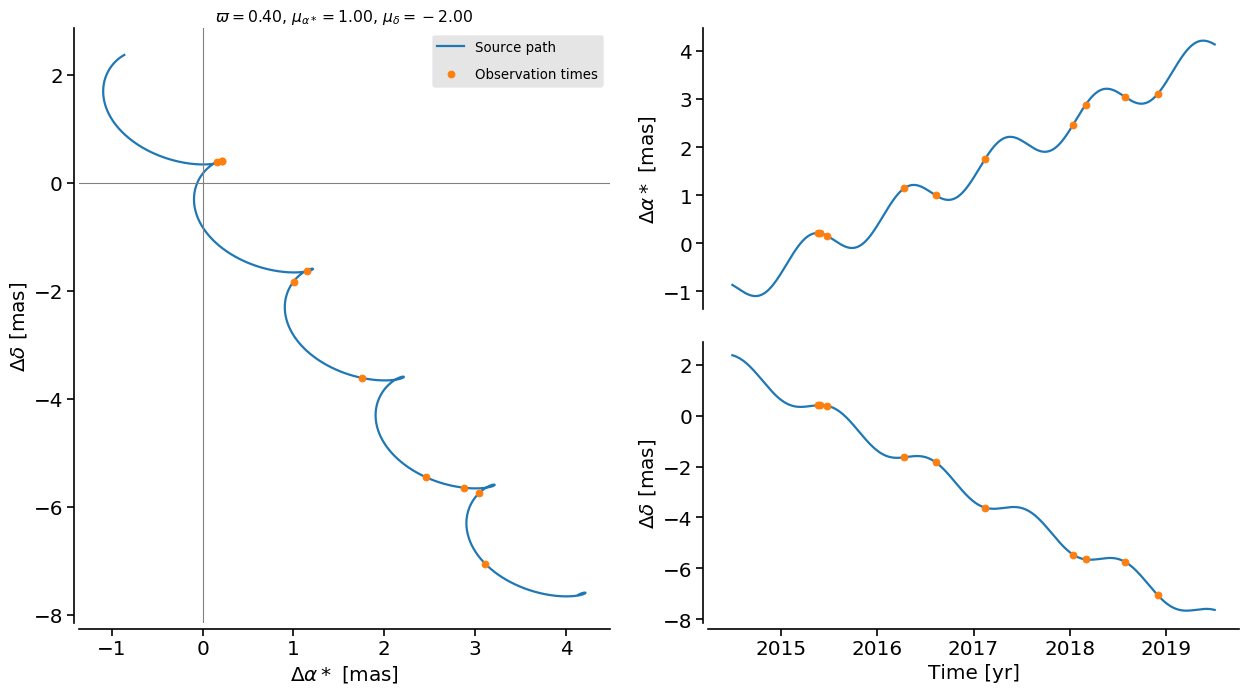

In [4]:
# source astrometric parameters at reference epoch

# Barnard's star
# For this star, which is close and has a large radial motion, the simplified astrometric solution will fail
# because perspective acceleration effects are not accounted for. This is seen in particular from the distribution
# of the reduced chi^2 values (all too high).
#
#alpha = 4.7028598776 #(66.0*units.degree).to(units.rad).value
#delta = 0.0814769927 #(16*units.degree).to(units.rad).value
#parallax = 548.31 # mas
#mura = -798.58          # mas/yr
#mudec = 10328.12        # mas/yr
#vrad = -110.51           # km/s

# Star at small parallax
alpha = (200.0*units.degree).to(units.rad).value
delta = (80.0*units.degree).to(units.rad).value
parallax = 0.4   # mas
mura =  1        # mas/yr
mudec = -2       # mas/yr
vrad = 40           # km/s

delta_alpha, delta_delta = calc_epochpos_topocentric(alpha, delta, parallax, mura, mudec,
                                                  vrad, time, refepoch, ephemeris_earth_simple)
delta_alpha_sample, delta_delta_sample, A = calc_epochpos_topocentric(alpha, delta, parallax, mura, mudec,
                                                                   vrad, tobs_sample, refepoch, 
                                                                   ephemeris_earth_simple, eqMat=True)

useagab(usetex=False, sroncolours=False, fontfam='sans')
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(121)
apply_tufte(ax)

ax.plot(delta_alpha, delta_delta, 
        label=r'Source path', lw=2)
ax.plot(delta_alpha_sample, delta_delta_sample, 'o', 
        label=r'Observation times'.
        format(parallax, mura, mudec), lw=2)
ax.set_xlabel(r'$\Delta\alpha*$ [mas]')
ax.set_ylabel(r'$\Delta\delta$ [mas]')
ax.axhline(y=0, c='gray', lw=1)
ax.axvline(x=0, c='gray', lw=1)
ax.legend(loc='upper right', fontsize=12,  facecolor='#000000', framealpha=0.1,
         labelspacing=1)
ax.set_title(r'$\varpi={0:.2f}$, $\mu_{{\alpha*}}={1:.2f}$, $\mu_\delta={2:.2f}$'.
        format(parallax, mura, mudec), fontsize=14)

ax1dra = fig.add_subplot(222)
apply_tufte(ax1dra)
ax1dra.spines['bottom'].set_visible(False)
ax1dra.xaxis.set_ticks([])
ax1dra.plot(time, delta_alpha)
ax1dra.plot(tobs_sample, delta_alpha_sample, 'o')
ax1dra.set_ylabel(r'$\Delta\alpha*$ [mas]')

ax1ddec = fig.add_subplot(224)
apply_tufte(ax1ddec)
ax1ddec.plot(time, delta_delta)
ax1ddec.plot(tobs_sample, delta_delta_sample, 'o')
ax1ddec.set_xlabel(r'Time [yr]')
ax1ddec.set_ylabel(r'$\Delta\delta$ [mas]')

plt.tight_layout()
plt.savefig('source_motion.pdf')
plt.show()

## Solving the equations for multiple realizations of the noise on the observations

The errors on the observations $\Delta\alpha*(t_i)$ and $\Delta\delta(t_i)$ are modelled as Gaussian and are assumed to be uncorrelated and free of systematics. For the same set of observation times multiple realizations of the observations are then generated according to

\begin{equation}
    \Delta\alpha*_\mathrm{obs} = {\cal N}(\Delta\alpha*_\mathrm{true}, \sigma_{\alpha*}) \quad\text{and}\quad
    \Delta\delta_\mathrm{obs} = {\cal N}(\Delta\delta_\mathrm{true}, \sigma_\delta)\,,
\end{equation}

where in this case $\sigma_{\alpha*} = \sigma_\delta = \sigma$. The equations are solved for each set of simulated observations and are of the form $\boldsymbol{A}\boldsymbol{x}=\boldsymbol{b}$. The formal covariance matrix of the least squares solution for $\boldsymbol{x}=(\varpi,\mu_{\alpha*},\mu_\delta)$ is given by

\begin{equation}
    \boldsymbol{C} = \sigma^2\left(\boldsymbol{A}'\boldsymbol{A}\right)^{-1}\,.
\end{equation}

This shows how the correlations between the parallax and proper motion uncertainties are determined by the source coordinate direction (through the projections of $\boldsymbol{b}_\mathrm{O}$ along $\boldsymbol{p}$ and $\boldsymbol{q}$) and, more importantly, by the distribution of the observation times. A more even distribution of observations times leading to less correlation.

The solution of the equations is repeated for $N_\mathrm{sims}$ realizations of the observations ($10\,000$ below, with exactly the same observation epochs $t_i$) and the resulting solutions for the parallax and proper motions are shown in the form of a corner plot. This plot nicely reflects the formal covariance matrix. The top right panel in the plot shows the distrbution of the reduced $\chi^2$ quantity given by

\begin{equation}
    \chi^2 = \frac{\left(\boldsymbol{A}\boldsymbol{x}-\boldsymbol{b}\right)'\boldsymbol{C}^{-1}
    \left(\boldsymbol{A}\boldsymbol{x}-\boldsymbol{b}\right)}{n-3}\,,
\end{equation}

which is a reduced $\chi^2$ with 3 degrees of freedom (for the three astrometric parameters estimated). The mathematical form of this distribution is well known and indicated by the blue line overplotted on the histogram. The fact that the histogram of the realized values of $\chi^2$ follows the expected form is an indication that the modelling of the observations was correct (as expected of course in this simple simulation). Deviations from the expected distribution occur when for example a high radial velocity of the source screws up the modelling of the observations (try Barnard's star in the code block above). Note that the oft quoted wisdom that the reduced $\chi^2$ of a least squares solution should be $1$, refers to the fact that the mode of the $\chi^2$ distribution is close to $1$ but there clearly is a (modest) spread in the actual values that can occur.

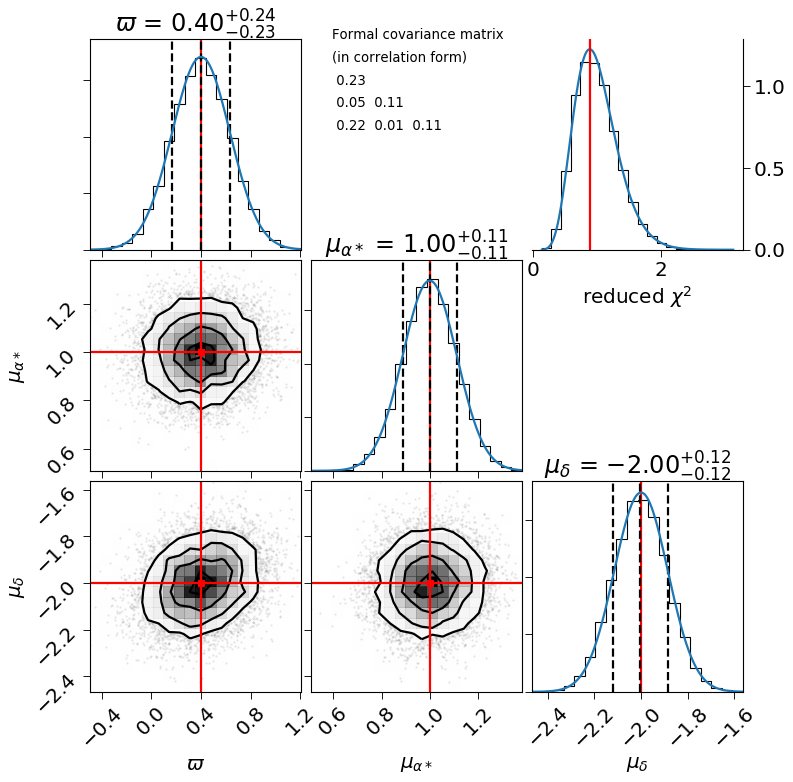

In [5]:
meas_unc = 0.7 # Instantaneous measurement uncertainty in alpha*cos(delta) and delta (mas)
covmat = inv(np.dot(A.T,A))*meas_unc**2

covmattext = "Formal covariance matrix\n(in correlation form)\n"
covmattext = covmattext + "{0:5.2f}\n".format(np.sqrt(covmat[0,0]))
covmattext = covmattext + "{0:5.2f} {1:5.2f}\n".format(covmat[1,0]/np.sqrt(covmat[0,0]*covmat[1,1]),
                                                     np.sqrt(covmat[1,1]))
covmattext = covmattext + "{0:5.2f} {1:5.2f} {2:5.2f}\n".format(covmat[2,0]/np.sqrt(covmat[0,0]*covmat[2,2]), 
                                       covmat[2,1]/np.sqrt(covmat[1,1]*covmat[2,2]),
                                       np.sqrt(covmat[2,2]))

# Make N realizations of the measurements for the same source at the same observing times.
Nsims = 10000
params = np.zeros((Nsims,3))
chisq = np.zeros(Nsims)
allobs = np.zeros((Nsims, 2*nobs))
dof = 2*nobs-3
for i in range(Nsims):
    delta_alpha_obs = norm.rvs(loc=delta_alpha_sample, scale=meas_unc)
    delta_delta_obs = norm.rvs(loc=delta_delta_sample, scale=meas_unc)
    zobs = np.hstack([delta_alpha_obs, delta_delta_obs])
    allobs[i] = zobs
    sol, residues, rank, s = lstsq(A/meas_unc, zobs/meas_unc)
    chisq[i] = residues/dof
    params[i] = sol
    
fig = plt.figure(figsize=(10,10))
ax = []
for i in range(1,10):
    ax.append(fig.add_subplot(3,3,i))
corner.corner(params, labels=[r'$\varpi$', r'$\mu_{\alpha*}$', r'$\mu_\delta$'], truths=[parallax, mura, mudec],
              truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=fig,
              hist_kwargs={'density':True})
x = np.linspace(params[:,0].min(), params[:,0].max(), 1000)
ax[0].plot(x, norm.pdf(x, loc=parallax, scale=np.sqrt(covmat[0,0])), lw=2)
x = np.linspace(params[:,1].min(), params[:,1].max(), 1000)
ax[4].plot(x, norm.pdf(x, loc=mura, scale=np.sqrt(covmat[1,1])), lw=2)
x = np.linspace(params[:,2].min(), params[:,2].max(), 1000)
ax[8].plot(x, norm.pdf(x, loc=mudec, scale=np.sqrt(covmat[2,2])), lw=2)

axchisq = fig.add_subplot(3,3,3, label='chisq')
axchisq.hist(chisq, bins=20, density=True, histtype='step', color='k')
x = np.linspace(chisq.min(), chisq.max(), 1000)
axchisq.plot(x, chi2.pdf(x*dof, dof)*dof, lw=2)
axchisq.set_xlabel(r'reduced $\chi^2$')
axchisq.yaxis.set_ticks_position('right')
axchisq.spines['left'].set_visible(False)
axchisq.spines['top'].set_visible(False)
axchisq.axvline(x=1.0-2.0/dof, color='r')

#axcov = fig.add_subplot(3,3,2, label='cov')
ax[4].text(0.1,1.8, covmattext, ha='left', va='center', linespacing=1.8, size=12, transform=ax[4].transAxes)

plt.savefig("simulated_lsq_solutions.pdf")
plt.show()

## Negative parallaxes from the least squares solution

The plot above shows the distribution of the parallaxes as solved for from the repeated simulations of the observed epoch positions of the source. The distribution is centred around the true parallax with a standard error according to the covariance matrix. This is as expected but note the presence of negative parallax solutions. These can always occur even if they become extremely unlikely when the measurement errors are small enough (i.e. the distribution of the parallax solutions is narrow and with a mean far from zero).

The code below takes the most negative parallax from the solutions above and shows the path of the source on the sky according to the observed astrometric parameters, as compared to the true path and the observations. Note how a negative parallax can be interpreted as the observer going the "wrong way around the sun" which is manifest in the opposite phases of the sinusoidal lines showing $\Delta\alpha*$ and $\Delta\delta$ as a function of time.

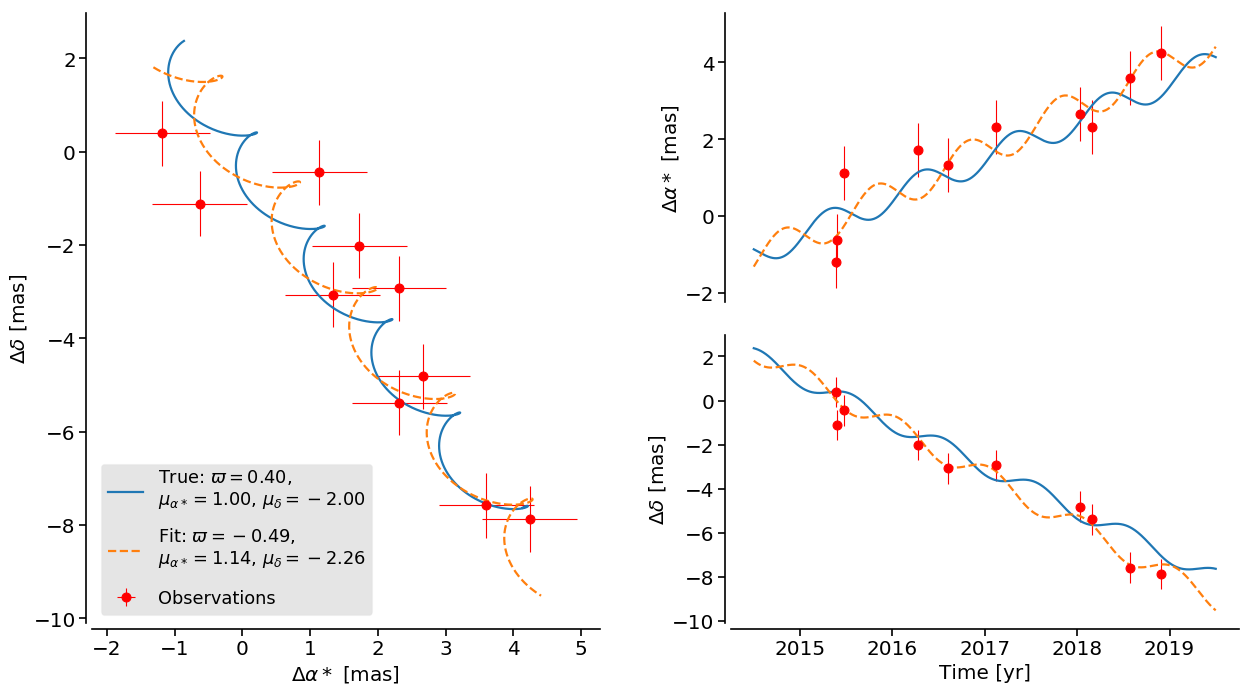

In [6]:
minparind = np.argmin(params[:,0])

delta_alpha_fit, delta_delta_fit = calc_epochpos_topocentric(alpha, delta, params[minparind,0], 
                                                             params[minparind,1], params[minparind,2],
                                                          vrad, time, refepoch, ephemeris_earth_simple)

useagab(usetex=False, sroncolours=False, fontfam='sans')
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(121)
apply_tufte(ax)

ax.plot(delta_alpha, delta_delta, 
        label=r'True: $\varpi={0:.2f}$,'.format(parallax)+'\n'+ r'$\mu_{{\alpha*}}={0:.2f}$, $\mu_\delta={1:.2f}$'.
        format(mura, mudec))
ax.plot(delta_alpha_fit, delta_delta_fit, 
        label=r'Fit: $\varpi={0:.2f}$,'.format(params[minparind,0])+'\n'+ 
        r'$\mu_{{\alpha*}}={0:.2f}$, $\mu_\delta={1:.2f}$'.
        format(params[minparind,1], params[minparind,2]), ls='--')
ax.errorbar(allobs[minparind,0:nobs], allobs[minparind,nobs:2*nobs], xerr=meas_unc, yerr=meas_unc, fmt='or', ms=8,
            label='Observations', elinewidth=1)
ax.set_xlabel(r'$\Delta\alpha*$ [mas]')
ax.set_ylabel(r'$\Delta\delta$ [mas]')
#ax.axhline(y=0, c='gray')
#ax.axvline(x=0, c='gray')
ax.legend(loc='lower left', fontsize=16,  facecolor='#000000', framealpha=0.1,
         labelspacing=1)
ax.set_title('')

ax1dra = fig.add_subplot(222)
apply_tufte(ax1dra)
ax1dra.spines['bottom'].set_visible(False)
ax1dra.xaxis.set_ticks([])
ax1dra.plot(time, delta_alpha)
ax1dra.plot(time, delta_alpha_fit, ls='--')
ax1dra.errorbar(tobs_sample, allobs[minparind,0:nobs], yerr=meas_unc, fmt='or', ms=8, elinewidth=1)
ax1dra.set_ylabel(r'$\Delta\alpha*$ [mas]')

ax1ddec = fig.add_subplot(224)
apply_tufte(ax1ddec)
ax1ddec.plot(time, delta_delta)
ax1ddec.plot(time, delta_delta_fit, ls='--')
ax1ddec.errorbar(tobs_sample, allobs[minparind,nobs:2*nobs], yerr=meas_unc, fmt='or', ms=8, elinewidth=1)
ax1ddec.set_xlabel(r'Time [yr]')
ax1ddec.set_ylabel(r'$\Delta\delta$ [mas]')

plt.tight_layout()
plt.savefig("minimum_parallax_solution.pdf")
plt.savefig("minimum_parallax_solution.png")
plt.show()